In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.callbacks import EarlyStopping

2024-11-22 10:16:04.236503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 10:16:04.236639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 10:16:04.375023: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = "../input/emotion-detection-fer/train" #passing the path with training images
test_dir = "../input/emotion-detection-fer/test"   #passing the path with testing images

In [3]:
img_size = 48

In [4]:
train_datagen = ImageDataGenerator(width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    rescale = 1/255,
                                    fill_mode = 'nearest',
                                    validation_split = 0.2
                                        )

validation_datagen = ImageDataGenerator(rescale = 1/255,
                                         validation_split = 0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )

validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [6]:
model= tf.keras.models.Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Fully Connected
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [7]:
epochs = 50
batch_size = 64

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    filepath='antarang_model.h5',    
    monitor='val_accuracy',          
    save_best_only=True,         
    mode='max',                  
    save_weights_only=False,     
    verbose=1                    
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 128)       512       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 128)       0         
 D)                                                              
                                                        

In [10]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator, callbacks=[checkpoint, lr_scheduler])

Epoch 1/50


2024-11-22 10:17:08.063684: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1732270632.088696     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/359 [==============================] - ETA: 0s - loss: 2.2288 - accuracy: 0.2184
Epoch 1: val_accuracy improved from -inf to 0.26047, saving model to antarang_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 124s 321ms/step - loss: 2.2288 - accuracy: 0.2184 - val_loss: 1.8394 - val_accuracy: 0.2605 - lr: 0.0010
Epoch 2/50
359/359 [==============================] - ETA: 0s - loss: 1.8591 - accuracy: 0.2748
Epoch 2: val_accuracy improved from 0.26047 to 0.34986, saving model to antarang_model.h5
359/359 [==============================] - 33s 92ms/step - loss: 1.8591 - accuracy: 0.2748 - val_loss: 1.6410 - val_accuracy: 0.3499 - lr: 0.0010
Epoch 3/50
359/359 [==============================] - ETA: 0s - loss: 1.6388 - accuracy: 0.3660
Epoch 3: val_accuracy improved from 0.34986 to 0.45251, saving model to antarang_model.h5
359/359 [==============================] - 35s 96ms/step - loss: 1.6388 - accuracy: 0.3660 - val_loss: 1.4570 - val_accuracy: 0.4525 - lr: 0.0010
Epoch 4/50
359/359 [==============================] - ETA: 0s - loss: 1.4753 - accuracy: 0.4320
Epoch 4: val_accuracy did not improve from 0.45251
359/359 [==============================] 

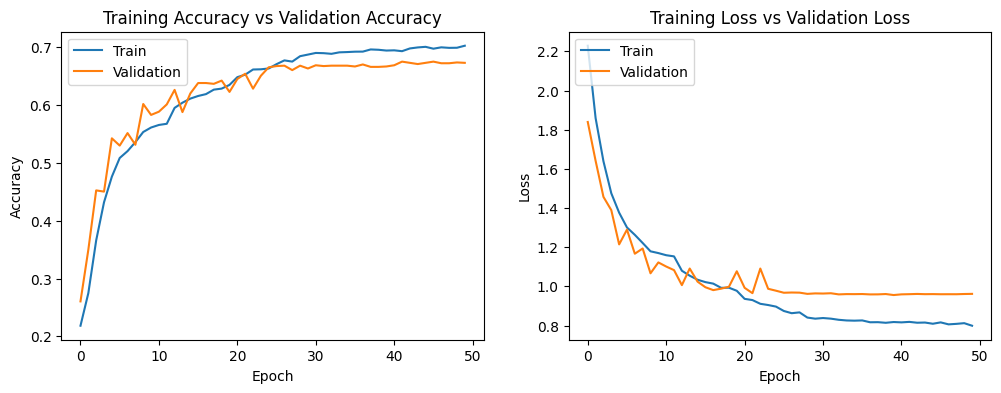

In [11]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

(48, 48)


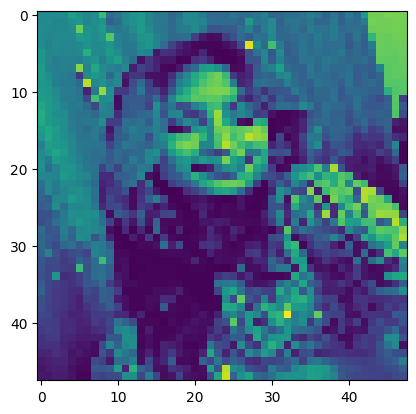

In [12]:
img = image.load_img("/kaggle/input/testing-image/TESTING123.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) 

In [13]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [14]:
img = np.expand_dims(img,axis = 0) 
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 [==============================] - 0s 407ms/step
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [15]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Angry


In [16]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 1s 51ms/step - loss: 0.9618 - accuracy: 0.6732
final train accuracy = 73.40 , validation accuracy = 67.32


23/23 [==============================] - 1s 52ms/step


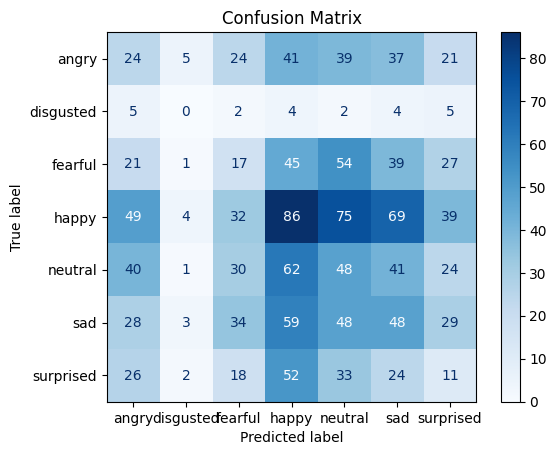

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = validation_generator.classes  
y_pred = np.argmax(model.predict(validation_generator), axis=-1)  

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [18]:
model.save_weights('model_weights.h5')